### Off-Platform Project:

# Bike Rental Data Management

## Library imports

In [1]:
import datetime

import pandas as pd
import numpy as np

import psycopg2

## Citi Bike Data

The Citi Bike data is stored in monthly files. 

In [2]:
# Read in files and concatenate them into a single dataframe
file_paths = ['JC-201601-citibike-tripdata.csv','JC-201602-citibike-tripdata.csv', 'JC-201603-citibike-tripdata.csv', 'JC-201604-citibike-tripdata.csv', 'JC-201605-citibike-tripdata.csv', 'JC-201606-citibike-tripdata.csv', 'JC-201607-citibike-tripdata.csv', 'JC-201608-citibike-tripdata.csv', 'JC-201609-citibike-tripdata.csv', 'JC-201610-citibike-tripdata.csv', 'JC-201611-citibike-tripdata.csv', 'JC-201612-citibike-tripdata.csv']
dataframes = []

for file_path in file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)
    
bike_df = pd.concat(dataframes, axis=0)

# Reset the index after concatenation
bike_df.reset_index(drop=True, inplace=True)

# Add an 'id' column which is useful for a primary key
bike_df['id'] = bike_df.index

Inspect the beginning and end of the dataset:

In [3]:
bike_df.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,id
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,Subscriber,1964.0,2,0
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,Subscriber,1962.0,1,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,Subscriber,1962.0,2,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,Subscriber,1984.0,1,3
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0,4


In [4]:
bike_df.tail()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,id
247579,557,2016-12-31 23:10:16,2016-12-31 23:19:33,3214,Essex Light Rail,40.712774,-74.036486,3203,Hamilton Park,40.727596,-74.044247,24465,Subscriber,1981.0,2,247579
247580,2749,2016-12-31 23:29:39,2017-01-01 00:15:29,3183,Exchange Place,40.716247,-74.033459,3183,Exchange Place,40.716247,-74.033459,24389,Customer,NaN,0,247580
247581,173,2016-12-31 23:44:37,2016-12-31 23:47:31,3186,Grove St PATH,40.719586,-74.043117,3270,Jersey & 6th St,40.725289,-74.045572,24641,Subscriber,1978.0,1,247581
247582,2424,2016-12-31 23:44:50,2017-01-01 00:25:14,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,26219,Subscriber,1960.0,2,247582
247583,2419,2016-12-31 23:44:50,2017-01-01 00:25:10,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,24471,Subscriber,1956.0,1,247583


Inital Observations:
* There are ~250k records(based on the index)
* According to the data dictionary:
    * `Trip Duration` is in seconds
    * `Gender` can be 0=unknown, 1=male, 2=female
    * `User Type` has values Customer=24-hour pass or 3-day pass user and Subscriber=Annual Member
    
Explore numeric fields:

In [5]:
bike_df.describe()

,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender,id
count,2.475840e+05,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,228585.000000,247584.000000,247584.000000
mean,8.856305e+02,3207.065206,40.723121,-74.046438,3203.572553,40.722594,-74.045855,24935.260481,1979.335276,1.123534,123791.500000
std,3.593798e+04,26.955103,0.008199,0.011211,61.579494,0.007958,0.011283,748.469712,9.596809,0.518687,71471.488861
min,6.100000e+01,3183.000000,40.692640,-74.096937,147.000000,40.692216,-74.096937,14552.000000,1900.000000,0.000000,0.000000
25%,2.480000e+02,3186.000000,40.717732,-74.050656,3186.000000,40.716540,-74.050444,24491.000000,1974.000000,1.000000,61895.750000
50%,3.900000e+02,3201.000000,40.721525,-74.044247,3199.000000,40.721124,-74.043117,24609.000000,1981.000000,1.000000,123791.500000
75%,6.660000e+02,3211.000000,40.727596,-74.038051,3211.000000,40.727224,-74.036486,24719.000000,1986.000000,1.000000,185687.250000
max,1.632981e+07,3426.000000,40.752559,-74.032108,3426.000000,40.801343,-73.957390,27274.000000,2000.000000,2.000000,247583.000000


Observations:

`Birth Year` has a minimum value of 1900, which corresponds to age 116
`Birth Year` might be missing some values

In [6]:
bike_df.isna().sum()

Trip Duration                  0
Start Time                     0
Stop Time                      0
Start Station ID               0
Start Station Name             0
Start Station Latitude         0
Start Station Longitude        0
End Station ID                 0
End Station Name               0
End Station Latitude           0
End Station Longitude          0
Bike ID                        0
User Type                    380
Birth Year                 18999
Gender                         0
id                             0
dtype: int64

In [7]:
bike_df.duplicated().sum()

0

Explore data types:

In [8]:
bike_df.dtypes

Trip Duration                int64
Start Time                  object
Stop Time                   object
Start Station ID             int64
Start Station Name          object
Start Station Latitude     float64
Start Station Longitude    float64
End Station ID               int64
End Station Name            object
End Station Latitude       float64
End Station Longitude      float64
Bike ID                      int64
User Type                   object
Birth Year                 float64
Gender                       int64
id                           int64
dtype: object

`Start Time` and `Stop Time` need to be datetimes. `Birth Year` also has an incorrect data type.

In [9]:
# cast objects as timestamps
bike_df['Start Time'] = pd.to_datetime(bike_df['Start Time'],infer_datetime_format=True)
bike_df['Stop Time'] = pd.to_datetime(bike_df['Stop Time'],infer_datetime_format=True)

bike_df.dtypes

Trip Duration                       int64
Start Time                 datetime64[ns]
Stop Time                  datetime64[ns]
Start Station ID                    int64
Start Station Name                 object
Start Station Latitude            float64
Start Station Longitude           float64
End Station ID                      int64
End Station Name                   object
End Station Latitude              float64
End Station Longitude             float64
Bike ID                             int64
User Type                          object
Birth Year                        float64
Gender                              int64
id                                  int64
dtype: object

## Cleaning and Transforming Citibike Data

In [10]:
# removing spaces and uppercase letters from the column names
bike_df.columns = [x.replace(' ', '_').lower() for x in bike_df.columns]

In [11]:
bike_df.columns

Index(['trip_duration', 'start_time', 'stop_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'birth_year', 'gender', 'id'],
      dtype='object')

Areas to investigate:
* Investigate both `birth_year` and `user_type`:
    * `birth_year`has suspiciously small minimum and missing data
    * `user_type` has missing data
* Investigate `trip_duration` has suspiciously large maximum
* Investigate `gender`--there's no missing data but we know from the dictionary that 0 corresponds to Unknown

## `birth_year`

In [12]:
# Calculate an approximate age and investigate the large outlier
bike_df['age'] = 2016 - bike_df['birth_year'].values
bike_df['age'].sort_values(ascending=False)[:10]

215055    116.0
136211     82.0
164274     79.0
187190     79.0
180373     79.0
213567     79.0
177320     76.0
112336     76.0
149803     76.0
124501     75.0
Name: age, dtype: float64

There's a single outlier of 116. We'll remove that from the dataset, since it will alter statistical analyses and we're not expecting other riders with that age.

In [13]:
bike_df.drop([215055], inplace=True)

Look at missing data in `birth_year`

In [14]:
missing_birth_year = bike_df[bike_df[['birth_year']].isnull().any(axis=1)]
missing_birth_year.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0,4,NaN
5,883,2016-01-01 01:03:28,2016-01-01 01:18:11,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24442,Customer,NaN,0,5,NaN
22,988,2016-01-01 03:16:33,2016-01-01 03:33:02,3196,Riverview Park,40.744319,-74.043991,3209,Brunswick St,40.724176,-74.050656,24662,Customer,NaN,0,22,NaN
53,3090,2016-01-01 11:07:15,2016-01-01 11:58:46,3203,Hamilton Park,40.727596,-74.044247,3203,Hamilton Park,40.727596,-74.044247,24444,Customer,NaN,0,53,NaN
57,788,2016-01-01 11:50:30,2016-01-01 12:03:39,3210,Pershing Field,40.742677,-74.051789,3195,Sip Ave,40.730743,-74.063784,24573,Customer,NaN,0,57,NaN


Observations:

* The first five are all customers
* The first five all have unknown gender

Checking to see if the pattern holds up:

In [15]:
missing_birth_year['user_type'].value_counts(dropna=False)

Customer      15470
Subscriber     3529
Name: user_type, dtype: int64

In [16]:
missing_birth_year['gender'].value_counts()

0    18999
Name: gender, dtype: int64

Observations:

* All records with a missing birth_year also have an unknown gender
* Customer user_type seems to be missing a lot of birth_year data

Percentages for user_type:

In [17]:
missing_birth_year['user_type'].value_counts() / bike_df['user_type'].value_counts()

Customer      0.996714
Subscriber    0.015232
Name: user_type, dtype: float64

Observations:

- 99% of Customers are missing `birth_year`
- 1.5% of Subscribers are missing `birth_year`
- All records with missing `birth_year` also have an unknown `gender`, which likely also corresponds to the Customer `user_type`

Keep this missing data in mind when developing the database.

## `user_type`

There were 380 missing records for `user_type`. Check to see if these records are also missing `birth_year` or have unknown `gender`.

In [18]:
missing_user_type = bike_df[bike_df[['user_type']].isnull().any(axis=1)]
((missing_user_type['gender'] == 0) | (missing_user_type['birth_year'].isna())).sum()

0

Given this result, these are most likely Subscribers, but it is possible they are Customers. 

Missing data over the course of the year:

In [19]:
missing_user_type.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age
25267,156,2016-03-23 09:08:34,2016-03-23 09:11:11,3214,Essex Light Rail,40.712774,-74.036486,3183,Exchange Place,40.716247,-74.033459,24444,NaN,1987.0,1,25267,29.0
25668,164,2016-03-23 22:17:45,2016-03-23 22:20:29,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,24675,NaN,1987.0,1,25668,29.0
25894,171,2016-03-24 11:46:39,2016-03-24 11:49:31,3214,Essex Light Rail,40.712774,-74.036486,3183,Exchange Place,40.716247,-74.033459,24697,NaN,1987.0,1,25894,29.0
26189,204,2016-03-24 20:45:45,2016-03-24 20:49:10,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,24387,NaN,1987.0,1,26189,29.0
26630,380,2016-03-25 19:15:56,2016-03-25 19:22:17,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,24412,NaN,1987.0,1,26630,29.0


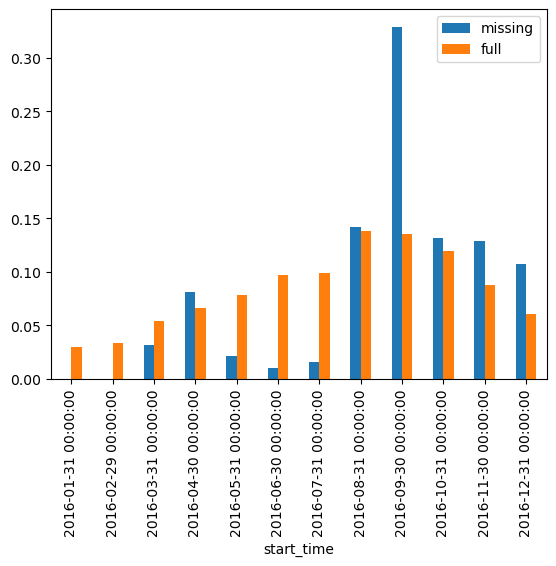

In [20]:
my = (missing_user_type.resample('M',on='start_time').count()['id']/len(missing_user_type)).rename('missing')
dy = (bike_df.resample('M',on='start_time').count()['id']/len(bike_df)).rename('full')
combo = pd.concat([my,dy],axis=1)


ax = combo.plot.bar();

While the missing data is a small percentage of the total, looking at the data, distributions indicate that it might not be missing at random. 
From a data management perspective, keep the data but replace the NaN with an unknown category--the analytics team can investigate further and we can keep track of this issue if we update the database with more years of data.

In [21]:
bike_df.fillna({'user_type':'Unknown'},inplace=True)

## `trip_duration`

Investigate suspiciously large maximum:

In [22]:
# creating an easier to interpret trip time column in minutes and hours
bike_df['trip_minutes'] = round(bike_df['trip_duration'] / 60, 2)
bike_df['trip_hours'] = round(bike_df['trip_duration']/(60**2),2)
bike_df[['trip_duration','trip_minutes','trip_hours']].describe()

,trip_duration,trip_minutes,trip_hours
count,2.475830e+05,247583.000000,247583.000000
mean,8.856300e+02,14.760494,0.246006
std,3.593805e+04,598.967493,9.982797
min,6.100000e+01,1.020000,0.020000
25%,2.480000e+02,4.130000,0.070000
50%,3.900000e+02,6.500000,0.110000
75%,6.660000e+02,11.100000,0.180000
max,1.632981e+07,272163.470000,4536.060000


Observations:

- Minimum trip length = 61 seconds
- Maximum trip = 4,536 hours =189 days
According to the data dictionary, trips under 60 seconds were already assumed to be false starts/stops and were pruned.

For the max, Citi Bike policies state that the maximum length of a trip is 24 hours (or 86400 seconds).

Won't delete the longer trips, since it is possible these correspond to bike docking issues or users breaking the rules (which analysts might want to investigate). Will add a flag so that the analytics team can easily filter these out if desired.

In [23]:
# create a column to flag rides that do not comply with system protocols
bike_df['valid_duration'] = bike_df['trip_duration'].apply(lambda x: 0 if x > 86400 else 1).astype(bool)

In [24]:
bike_df.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age,trip_minutes,trip_hours,valid_duration
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,Subscriber,1964.0,2,0,52.0,6.03,0.10,True
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,Subscriber,1962.0,1,1,54.0,3.33,0.06,True
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,Subscriber,1962.0,2,2,54.0,3.37,0.06,True
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,Subscriber,1984.0,1,3,32.0,4.13,0.07,True
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0,4,NaN,15.05,0.25,True


## `gender`

Check that most unknown genders correspond to `user_type` = Customer

In [25]:
bike_df.groupby(['user_type','gender']).count()['id']

user_type   gender
Customer    0          15470
            1             36
            2             15
Subscriber  0           4431
            1         176898
            2          50353
Unknown     1            262
            2            118
Name: id, dtype: int64

Observation:

Demographic information is only useful for `user_type` = Subscriber.

## Weather Data

In [26]:
weather_df = pd.read_csv('newark_airport_2016.csv')
weather_df.head()

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
0,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-01,12.75,NaN,0.0,0.0,0.0,41,43,34,NaN,270,280.0,25.9,35.1
1,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-02,9.40,NaN,0.0,0.0,0.0,36,42,30,NaN,260,260.0,21.0,25.1
2,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-03,10.29,NaN,0.0,0.0,0.0,37,47,28,NaN,270,250.0,23.9,30.0
3,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-04,17.22,NaN,0.0,0.0,0.0,32,35,14,NaN,330,330.0,25.9,33.1
4,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-05,9.84,NaN,0.0,0.0,0.0,19,31,10,NaN,360,350.0,25.1,31.1


In [27]:
weather_df.tail()

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
361,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-12-27,13.65,NaN,0.01,0.0,0.0,53,62,40,NaN,270,270.0,29.1,38.0
362,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-12-28,8.28,NaN,0.00,0.0,0.0,41,43,31,NaN,330,330.0,19.9,25.1
363,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-12-29,8.05,NaN,0.36,0.0,0.0,38,45,31,NaN,170,150.0,18.1,25.1
364,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-12-30,14.99,NaN,0.00,0.0,0.0,37,42,32,NaN,270,270.0,25.9,33.1
365,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-12-31,12.30,NaN,0.00,0.0,0.0,35,44,29,NaN,200,220.0,21.9,28.0


In [28]:
weather_df.describe()

,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
count,366.000000,0.0,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,0.0,366.000000,364.000000,366.000000,364.000000
mean,9.429973,NaN,0.104945,0.098087,0.342623,57.196721,65.991803,48.459016,NaN,217.841530,228.269231,20.484426,26.801648
std,3.748174,NaN,0.307496,1.276498,2.078510,17.466981,18.606301,17.135790,NaN,102.548282,97.415777,6.848390,8.882610
min,2.460000,NaN,0.000000,0.000000,0.000000,8.000000,18.000000,0.000000,NaN,10.000000,10.000000,6.900000,10.100000
25%,6.765000,NaN,0.000000,0.000000,0.000000,43.000000,51.250000,35.000000,NaN,150.000000,150.000000,15.000000,19.900000
50%,8.720000,NaN,0.000000,0.000000,0.000000,56.000000,66.000000,47.000000,NaN,240.000000,260.000000,19.900000,25.100000
75%,11.410000,NaN,0.030000,0.000000,0.000000,74.000000,83.000000,64.000000,NaN,300.000000,300.000000,23.900000,31.100000
max,22.820000,NaN,2.790000,24.000000,20.100000,89.000000,99.000000,80.000000,NaN,360.000000,360.000000,48.100000,66.000000


## Cleaning and Transforming Weather Data

`PGTM` (peak gust time) and `TSUN` (total minutes of sun) are entirely missing and will be dropped. `WDFx` and `WSFx` refer to the fastest x-minute wind, and are difficult to connect directly to our data (since we don't know when that speed occurred.) We'll therefore stick with `AWND` (average wind speed) for our wind-speed variable.

All our data is from the same station, we'll drop those details for now.

In [29]:
weather_df.drop(['STATION','NAME','PGTM','TSUN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'],axis=1, inplace=True)

Explore data types:

In [30]:
weather_df.dtypes

DATE     object
AWND    float64
PRCP    float64
SNOW    float64
SNWD    float64
TAVG      int64
TMAX      int64
TMIN      int64
dtype: object

In [31]:
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'],yearfirst=True)
weather_df.dtypes

DATE    datetime64[ns]
AWND           float64
PRCP           float64
SNOW           float64
SNWD           float64
TAVG             int64
TMAX             int64
TMIN             int64
dtype: object

Explore numeric fields:

In [32]:
weather_df.describe()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,9.429973,0.104945,0.098087,0.342623,57.196721,65.991803,48.459016
std,3.748174,0.307496,1.276498,2.078510,17.466981,18.606301,17.135790
min,2.460000,0.000000,0.000000,0.000000,8.000000,18.000000,0.000000
25%,6.765000,0.000000,0.000000,0.000000,43.000000,51.250000,35.000000
50%,8.720000,0.000000,0.000000,0.000000,56.000000,66.000000,47.000000
75%,11.410000,0.030000,0.000000,0.000000,74.000000,83.000000,64.000000
max,22.820000,2.790000,24.000000,20.100000,89.000000,99.000000,80.000000


Observations:

- No obvious outliers.
- Temperatures are Fahrenheut and precipitation/snow amounts in inches.

Check for null values:

In [33]:
weather_df.isnull().sum()

DATE    0
AWND    0
PRCP    0
SNOW    0
SNWD    0
TAVG    0
TMAX    0
TMIN    0
dtype: int64

In [34]:
# rename columns
weather_df.columns = ['rec_date','avg_wind','prcp','snow_amt','snow_depth','tavg','tmax','tmin']

# create convenience binary columns for weather events
weather_df['rain'] = weather_df['prcp'].apply(lambda x: 1 if x > 0 else 0).astype(bool)
weather_df['snow'] = weather_df['snow_amt'].apply(lambda x: 1 if x > 0 else 0).astype(bool)

In [35]:
weather_df.head()

,rec_date,avg_wind,prcp,snow_amt,snow_depth,tavg,tmax,tmin,rain,snow
0,2016-01-01,12.75,0.0,0.0,0.0,41,43,34,False,False
1,2016-01-02,9.40,0.0,0.0,0.0,36,42,30,False,False
2,2016-01-03,10.29,0.0,0.0,0.0,37,47,28,False,False
3,2016-01-04,17.22,0.0,0.0,0.0,32,35,14,False,False
4,2016-01-05,9.84,0.0,0.0,0.0,19,31,10,False,False


In [36]:
weather_df.tail()

,rec_date,avg_wind,prcp,snow_amt,snow_depth,tavg,tmax,tmin,rain,snow
361,2016-12-27,13.65,0.01,0.0,0.0,53,62,40,True,False
362,2016-12-28,8.28,0.00,0.0,0.0,41,43,31,False,False
363,2016-12-29,8.05,0.36,0.0,0.0,38,45,31,True,False
364,2016-12-30,14.99,0.00,0.0,0.0,37,42,32,False,False
365,2016-12-31,12.30,0.00,0.0,0.0,35,44,29,False,False


## Creating the Database

See the schema for the final database [here](bike_rental_ERD.pdf) for more information.

Implementing the schema in a Postgres database and inserting the data.

In [37]:
# create a connection to the database
try:
    conn = psycopg2.connect("host=localhost dbname=postgres user=postgres password=postgres")
except psycopg2.Error as e:
    print("Error: Could not make connection to the Postgres database")
    print(e)

In [38]:
# use the connection to get a cursor that can be used to execute queries
try:
    cur = conn.cursor()
except psycopg2.Error as e:
    print("Error: Could not get cursor to the database")
    print(e)

In [39]:
# Set automatic commit to be true to call conn.commit() after each command
conn.set_session(autocommit=True)

In [40]:
# create a database
try:
    cur.execute("CREATE DATABASE bike_rental_db")
except psycopg2.Error as e:
    print(e)

In [41]:
try:
    conn.close()
except psycopg2.Error as e:
    print(e)
    
try:
    conn = psycopg2.connect("host=localhost dbname=bike_rental_db user=postgres password=postgres")
except psycopg2.Error as e:
    print("Error: Could not make connection to the Postgres database")
    print(e)
    
try:
    cur = conn.cursor()
except psycopg2.Error as e:
    print("Error: Could not get cursor to the database")
    print(e)
    
conn.set_session(autocommit=True)

## PostgreSQL Tables

### Date Table

In [42]:
# our data starts on 2016-01-01
start = datetime.datetime(2016,1,1)
# generate the remaining days of the year -- leap year!
date_col = [start + datetime.timedelta(x) for x in range(366)]
# create a dataframe
date_df = pd.DataFrame(date_col, dtype='datetime64[ns]')
date_df.columns = ['full_date']
date_df.head()

,full_date
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05


In [43]:
# generate month and day names
date_df['month'] = date_df['full_date'].apply(lambda x: x.month)
date_df['day'] = date_df['full_date'].apply(lambda x: x.day)
date_df['month_name'] = date_df['full_date'].apply(lambda x: x.strftime('%B'))
date_df['day_name'] = date_df['full_date'].apply(lambda x: x.strftime('%A'))
date_df['weekend'] = date_df['day_name'].apply(lambda x: 1 if (x == 'Saturday' or x=='Sunday') else 0).astype(bool)
date_df.head()

,full_date,month,day,month_name,day_name,weekend
0,2016-01-01,1,1,January,Friday,False
1,2016-01-02,1,2,January,Saturday,True
2,2016-01-03,1,3,January,Sunday,True
3,2016-01-04,1,4,January,Monday,False
4,2016-01-05,1,5,January,Tuesday,False


In [44]:
# helper function to generate financial quarters
def get_quarter(x):
    if x <= 3:
        return 1
    elif x <= 6:
        return 2
    elif x <= 9:
        return 3
    else:
        return 4        

# add financial quarters
date_df['financial_qtr'] = date_df['month'].apply(get_quarter)
date_df.head()

,full_date,month,day,month_name,day_name,weekend,financial_qtr
0,2016-01-01,1,1,January,Friday,False,1
1,2016-01-02,1,2,January,Saturday,True,1
2,2016-01-03,1,3,January,Sunday,True,1
3,2016-01-04,1,4,January,Monday,False,1
4,2016-01-05,1,5,January,Tuesday,False,1


In [45]:
date_df['date_key'] = date_df['full_date'].apply(lambda x: int(x.strftime('%Y%m%d').strip('-')))
weather_df['date_key'] = weather_df['rec_date'].apply(lambda x: int(x.strftime('%Y%m%d').strip('-')))
bike_df['date_key'] = bike_df['start_time'].apply(lambda x: int(x.strftime('%Y%m%d').strip('-')))

# take a look at the head and tail of the date table
date_df.head()

,full_date,month,day,month_name,day_name,weekend,financial_qtr,date_key
0,2016-01-01,1,1,January,Friday,False,1,20160101
1,2016-01-02,1,2,January,Saturday,True,1,20160102
2,2016-01-03,1,3,January,Sunday,True,1,20160103
3,2016-01-04,1,4,January,Monday,False,1,20160104
4,2016-01-05,1,5,January,Tuesday,False,1,20160105


In [46]:
date_df.tail()

,full_date,month,day,month_name,day_name,weekend,financial_qtr,date_key
361,2016-12-27,12,27,December,Tuesday,False,4,20161227
362,2016-12-28,12,28,December,Wednesday,False,4,20161228
363,2016-12-29,12,29,December,Thursday,False,4,20161229
364,2016-12-30,12,30,December,Friday,False,4,20161230
365,2016-12-31,12,31,December,Saturday,True,4,20161231


In [47]:
# check data types
date_df.dtypes

full_date        datetime64[ns]
month                     int64
day                       int64
month_name               object
day_name                 object
weekend                    bool
financial_qtr             int64
date_key                  int64
dtype: object

In [48]:
try:
    cur.execute("CREATE TABLE date (date_key int PRIMARY KEY, full_date timestamp,\
    month int, day int, month_name varchar(10), day_name varchar(10), weekend boolean, financial_qtr int);")
except psycopg2.Error as e:
    print("Error: Issue creating table")
    print(e)

In [49]:
column_order = ['date_key', 'full_date', 'month', 'day', 'month_name', 'day_name', 'weekend', 'financial_qtr']

#Rearrange the columns in the dataframe
date_df = date_df[column_order]

try:
    
    # SQL query to insert data into the table
    
    insert_query = """INSERT INTO date(date_key,
    full_date,
    month,
    day,
    month_name,
    day_name,
    weekend,
    financial_qtr)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
    """
    
    # Convert the DataFrame to a list of tuples
    date_table_insert = [tuple(row) for row in date_df.values]

    # Execute the query to insert the data
    cur.executemany(insert_query, date_table_insert)
    
except psycopg2.Error as e:
    print("Error: Issue inserting data")
    print(e)

finally:
    # Close the cursor and the connection
    cur.close()
    conn.close()

### Rider Demographics Table

In [50]:
# Create a demographics table with all the unique demographics in the original dataset
rider_demo = bike_df[['user_type','birth_year','gender','age']].drop_duplicates(subset=['user_type','birth_year','gender']).reset_index(drop=True)
rider_demo['rider_demo'] = rider_demo.index

# Add the rider_demo key to a ride table
ride = bike_df.merge(rider_demo, on=['user_type','birth_year','gender','age']).sort_values(by='id').reset_index(drop=True)

# drop the demographic info from ride
ride = ride.drop(['user_type','birth_year','gender','age'],axis=1)

ride.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,id,trip_minutes,trip_hours,valid_duration,date_key,rider_demo
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,0,6.03,0.10,True,20160101,0
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,1,3.33,0.06,True,20160101,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,2,3.37,0.06,True,20160101,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,3,4.13,0.07,True,20160101,3
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,4,15.05,0.25,True,20160101,4


In [51]:
# first merge the two tables and
# - sort by ID to match bike_df's sorting
# - reset the index to match bike_df's index
# - drop the rider_demo join key
ridemerge = ride.merge(rider_demo,on='rider_demo').sort_values(by='id').reset_index(drop=True).drop('rider_demo',axis=1)

# count the number of positions where ridemerge is different from bike_df
# note that NaN != NaN, so we also need to make sure at least one isn't NaN
(bike_df.ne(ridemerge) & (bike_df.notna() | ridemerge.notna())).sum()

age                        31223
bike_id                    32469
birth_year                 31223
date_key                      61
end_station_id             28806
end_station_latitude       28806
end_station_longitude      28806
end_station_name           28806
gender                     13242
id                         32528
start_station_id           29383
start_station_latitude     29383
start_station_longitude    29383
start_station_name         29383
start_time                 32201
stop_time                  32420
trip_duration              32460
trip_hours                 30240
trip_minutes               32460
user_type                   1154
valid_duration                25
dtype: int64

In [52]:
# change the name of the trip_demo id column for the database
rider_demo.rename(columns={'rider_demo':'id'}, inplace=True)
rider_demo.head()

,user_type,birth_year,gender,age,id
0,Subscriber,1964.0,2,52.0,0
1,Subscriber,1962.0,1,54.0,1
2,Subscriber,1962.0,2,54.0,2
3,Subscriber,1984.0,1,32.0,3
4,Customer,NaN,0,NaN,4


In [53]:
rider_demo.tail()

,user_type,birth_year,gender,age,id
204,Unknown,1993.0,1,23.0,204
205,Unknown,1963.0,1,53.0,205
206,Customer,1988.0,2,28.0,206
207,Unknown,1960.0,1,56.0,207
208,Unknown,1978.0,2,38.0,208


### Trip Table

In [54]:
# create tables of start stations and end stations
starts = ride[['start_station_id','start_station_name','start_station_latitude','start_station_longitude']]
ends = ride[['end_station_id','end_station_name','end_station_latitude','end_station_longitude']]

# rename so both start and end dataframes have the same column names
starts.columns = ['id','station_name','latitude','longitude']
ends.columns = ['id','station_name','latitude','longitude']

# concatenate and drop duplicates
station = pd.concat([starts,ends]).drop_duplicates()

# drop station names and locations from ride
trip = ride.drop(['start_station_name','start_station_latitude','start_station_longitude','end_station_name','end_station_latitude','end_station_longitude'],axis=1)

trip['date_key']

0         20160101
1         20160101
2         20160101
3         20160101
4         20160101
            ...   
247578    20161231
247579    20161231
247580    20161231
247581    20161231
247582    20161231
Name: date_key, Length: 247583, dtype: int64

In [55]:
trip['date_key'].dtype

dtype('int64')

In [56]:
trip.head()

,trip_duration,start_time,stop_time,start_station_id,end_station_id,bike_id,id,trip_minutes,trip_hours,valid_duration,date_key,rider_demo
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,3209,24647,0,6.03,0.10,True,20160101,0
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,3213,24605,1,3.33,0.06,True,20160101,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,3213,24689,2,3.37,0.06,True,20160101,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,3203,24693,3,4.13,0.07,True,20160101,3
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,3210,24573,4,15.05,0.25,True,20160101,4


In [57]:
# Rename rider_demo as rider_demo_id
trip = trip.rename(columns={'rider_demo': 'rider_demo_id'})

# Define the desired order of columns (including the newly renamed column)
trip_column_order = ['id', 'trip_duration', 'start_time', 'stop_time', 'start_station_id', 'end_station_id', 'bike_id', 'trip_minutes', 'trip_hours', 'valid_duration', 'date_key', 'rider_demo_id']

trip = trip[trip_column_order]

In [58]:
trip.head()

,id,trip_duration,start_time,stop_time,start_station_id,end_station_id,bike_id,trip_minutes,trip_hours,valid_duration,date_key,rider_demo_id
0,0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,3209,24647,6.03,0.10,True,20160101,0
1,1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,3213,24605,3.33,0.06,True,20160101,1
2,2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,3213,24689,3.37,0.06,True,20160101,2
3,3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,3203,24693,4.13,0.07,True,20160101,3
4,4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,3210,24573,15.05,0.25,True,20160101,4


In [59]:
trip.tail()

,id,trip_duration,start_time,stop_time,start_station_id,end_station_id,bike_id,trip_minutes,trip_hours,valid_duration,date_key,rider_demo_id
247578,247579,557,2016-12-31 23:10:16,2016-12-31 23:19:33,3214,3203,24465,9.28,0.15,True,20161231,58
247579,247580,2749,2016-12-31 23:29:39,2017-01-01 00:15:29,3183,3183,24389,45.82,0.76,True,20161231,4
247580,247581,173,2016-12-31 23:44:37,2016-12-31 23:47:31,3186,3270,24641,2.88,0.05,True,20161231,35
247581,247582,2424,2016-12-31 23:44:50,2017-01-01 00:25:14,3214,3214,26219,40.40,0.67,True,20161231,42
247582,247583,2419,2016-12-31 23:44:50,2017-01-01 00:25:10,3214,3214,24471,40.32,0.67,True,20161231,26


### Station Table

In [60]:
station.head()

,id,station_name,latitude,longitude
0,3186,Grove St PATH,40.719586,-74.043117
3,3209,Brunswick St,40.724176,-74.050656
4,3195,Sip Ave,40.730743,-74.063784
7,3211,Newark Ave,40.721525,-74.046305
8,3187,Warren St,40.721124,-74.038051


### Weather Table

In [61]:
weather_df.head()

,rec_date,avg_wind,prcp,snow_amt,snow_depth,tavg,tmax,tmin,rain,snow,date_key
0,2016-01-01,12.75,0.0,0.0,0.0,41,43,34,False,False,20160101
1,2016-01-02,9.40,0.0,0.0,0.0,36,42,30,False,False,20160102
2,2016-01-03,10.29,0.0,0.0,0.0,37,47,28,False,False,20160103
3,2016-01-04,17.22,0.0,0.0,0.0,32,35,14,False,False,20160104
4,2016-01-05,9.84,0.0,0.0,0.0,19,31,10,False,False,20160105


### Run CREATE TABLE queries and INSERT the data


In [62]:
try:
    conn = psycopg2.connect("host=localhost dbname=bike_rental_db user=postgres password=postgres")
except psycopg2.Error as e:
    print("Error: Could not make connection to the Postgres database")
    print(e)
    
try:
    cur = conn.cursor()
except psycopg2.Error as e:
    print("Error: Could not get cursor to the database")
    print(e)
    
conn.set_session(autocommit=True)

In [63]:
try:
    # CREATE TABLE for rider demographics
    cur.execute("""CREATE TABLE rider_demographics (
                id serial PRIMARY KEY, 
                user_type varchar(50), 
                birth_year float, 
                gender int, 
                age float);""")

    # Insert data into the rider_demographics table
    for _, row in rider_demo.iterrows():
        cur.execute("INSERT INTO rider_demographics (id, user_type, birth_year, gender, age) VALUES (%s, %s, %s, %s, %s);", (row['id'], row['user_type'], row['birth_year'], row['gender'], row['age']))

except psycopg2.Error as e:
    print("Error: Issue creating table or inserting data")
    print(e)


In [64]:
try:
    # CREATE TABLE for station
    cur.execute("""
        CREATE TABLE station (
            id serial PRIMARY KEY, 
            station_name varchar, 
        latitude float, 
        longitude float
        );
    """)
    
except psycopg2.Error as e:
    print("Error: Issue creating the Station Table")
    print(e)
    
try:
    # Insert data into the station table
    for _, row in station.iterrows():
        cur.execute("""
            INSERT INTO station (id, station_name, latitude, longitude)
            VALUES (%s, %s, %s, %s);
        """,
        (
            row['id'],
            row['station_name'],
            row['latitude'],
            row['longitude']
        ))

except psycopg2.Error as e:
    print("Error: Issue inserting data into the Station Table")
    print(e)

In [65]:
try:
    # CREATE TABLE for trip table
    cur.execute("""
        CREATE TABLE trip (
            id serial PRIMARY KEY,
            trip_duration int,
            start_time timestamp,
            stop_time timestamp,
            start_station_id int,
            end_station_id int,
            bike_id int,
            trip_minutes float,
            trip_hours float,
            valid_duration boolean,
            date_key int,
            rider_demo_id int,
            CONSTRAINT fk_trip_date_key FOREIGN KEY (date_key) REFERENCES date (date_key),
            CONSTRAINT fk_trip_rider_demo_id FOREIGN KEY (rider_demo_id) REFERENCES rider_demographics (id),
            CONSTRAINT fk_trip_start_station_id FOREIGN KEY (start_station_id) REFERENCES station (id),
            CONSTRAINT fk_trip_end_station_id FOREIGN KEY (end_station_id) REFERENCES station (id)
        );
    """)
    # Insert data into the trip table
    for _, row in trip.iterrows():
        cur.execute("""
            INSERT INTO trip (
                id, trip_duration, start_time, stop_time, start_station_id, end_station_id, bike_id,
                trip_minutes, trip_hours, valid_duration, date_key, rider_demo_id
            )
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
        """,
        (
            row['id'],
            row['trip_duration'],
            row['start_time'],
            row['stop_time'],
            row['start_station_id'],
            row['end_station_id'],
            row['bike_id'],
            row['trip_minutes'],
            row['trip_hours'],
            row['valid_duration'],
            row['date_key'],
            row['rider_demo_id']
            
            
        ))
        
except psycopg2.Error as e:
    print("Error: Issue inserting data into the Trip Table")
    print(e)

In [66]:
try:
    # CREATE TABLE for the Weather Table
    cur.execute("""
        CREATE TABLE weather (
            id serial PRIMARY KEY,
            rec_date date,
            avg_wind float,
            prcp float,
            snow_amt float,
            snow_depth float,
            tavg int,
            tmax int,
            tmin int,
            rain boolean,
            snow boolean,
            date_key int,
            CONSTRAINT fk_weather_date_key FOREIGN KEY (date_key) REFERENCES date (date_key)
        );
    """)


except psycopg2.Error as e:
    print("Error: Issue creating the Weather Table")
    print(e)

try:
    # Insert data into the weather table
    for _, row in weather_df.iterrows():
        cur.execute("""
            INSERT INTO weather (
                rec_date, 
                avg_wind, 
                prcp, 
                snow_amt, 
                snow_depth, 
                tavg, 
                tmax, 
                tmin, 
                rain, 
                snow, 
                date_key
            )
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
        """,
        (
            row['rec_date'],
            row['avg_wind'],
            row['prcp'],
            row['snow_amt'],
            row['snow_depth'],
            row['tavg'],
            row['tmax'],
            row['tmin'],
            row['rain'],
            row['snow'],
            row['date_key']
        ))


except psycopg2.Error as e:
    print("Error: Issue inserting data into the Weather Table")
    print(e)
    
finally:
    # Close the cursor and the connection
    cur.close()
    conn.close()